In [ ]:
%load_ext autoreload
%autoreload 2
!source /home/murilo/RelNetCare/.env

In [58]:
from transformers import AutoTokenizer
import torch
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

exp_group = "DialogREBARTSummarizeRelationsLargerModel"  # Change this for each run
data_folder = "/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART"
freeze_encoder = False

# Initialize Weights and Biases with more args
args_dict = {
    "per_device_train_batch_size": 8, #bart-base 32
    "per_device_eval_batch_size": 12, #bart-base 64
    "num_train_epochs": 5,
    'learning_rate': 2e-5,  # good starting point
    "exp_group": exp_group,
    "data_stem": data_folder.split('/')[-1],
    "data_folder": data_folder,
    "freeze_encoder": freeze_encoder,
    'truncation': True,
    'max_length': 1024,
    'model_name':'facebook/bart-large',
    'memorization_task': False,
    'fp16': False,
    'merge_train_dev': False
}
args_dict['output_dir'] = f"/mnt/vdb1/murilo/models/fine-tuned/{args_dict['model_name']}/{args_dict['data_stem']}"


checkpoint = args_dict['model_name']
tokenizer = AutoTokenizer.from_pretrained(args_dict['model_name'])

In [59]:
from datasets import Dataset, DatasetDict
import os
import json

data_cap = -1
set_data = None
dataset_sets = {}
dict_sets = {}
for set_ in ('train', 'test', 'dev'):

    data_path = os.path.join(data_folder, f'{set_}.json')

    with open(data_path, 'r') as f:
        data = json.load(f)
            
    # Remap keys and separate into train/test
    if args_dict['memorization_task']:
        if not set_data:
            set_data = [{"text": item["input"], "summary": item["output"], "title": ""} for item in data[data_cap:]]
    else:
        set_data = [{"text": item["input"], "summary": item["output"], "title": ""} for item in data]
        
    # Merge 'train' and 'dev' if the flag is set
    if args_dict['merge_train_dev']:
        if set_ == 'dev':
            dict_sets['train'] = dict_sets['train'] + set_data
        else:
           dict_sets[set_] = set_data
    else:
        dict_sets[set_] = set_data
        

    
for set_ in ('train', 'test', 'dev'):
    if args_dict['merge_train_dev']:
        if set_ == 'dev':
            continue
    set_data = dict_sets[set_]
    dataset_sets[set_] = Dataset.from_dict(
        {"text": [item["text"] for item in set_data],
         "summary": [item["summary"] for item in set_data],
         "title": [item["title"] for item in set_data]}
        )
    

# Create DatasetDict
dataset_dict = DatasetDict(dataset_sets)
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 2304
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 841
    })
    dev: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 705
    })
})

In [60]:
def preprocess_function(examples, model_max_length=args_dict['max_length'], tokenizer_max_length=args_dict['max_length']):
    inputs = [doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=model_max_length, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=model_max_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_data = dataset_dict.map(preprocess_function, batched=True)


Map: 100%|██████████| 705/705 [00:00<00:00, 8209.58 examples/s]


In [61]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=args_dict['model_name'])

In [62]:
import evaluate

rouge = evaluate.load("rouge")

In [63]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [64]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model.to(device)
args_dict


{'per_device_train_batch_size': 8,
 'per_device_eval_batch_size': 12,
 'num_train_epochs': 5,
 'learning_rate': 2e-05,
 'exp_group': 'DialogREBARTSummarizeRelationsLargerModel',
 'data_stem': 'dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART',
 'data_folder': '/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART',
 'freeze_encoder': False,
 'truncation': True,
 'max_length': 1024,
 'model_name': 'facebook/bart-large',
 'memorization_task': False,
 'fp16': False,
 'merge_train_dev': False,
 'output_dir': '/mnt/vdb1/murilo/models/fine-tuned/facebook/bart-large/dialog-re-llama-11cls-rebalPairs-rwrtKeys-instrC-mxTrnCp3-skpTps-prepBART'}

In [65]:
wandb.init(project="huggingface", config=args_dict, reinit=True)

training_args = Seq2SeqTrainingArguments(
    output_dir=args_dict['output_dir'],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=1,
    learning_rate=args_dict['learning_rate'],
    per_device_train_batch_size=args_dict['per_device_train_batch_size'],
    per_device_eval_batch_size=args_dict['per_device_eval_batch_size'],
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=args_dict['num_train_epochs'],
    predict_with_generate=True,
    fp16=args_dict['fp16'],
    load_best_model_at_end=True
    # push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
# @todo: set random seed fo training
trainer.train()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/gen_len,▇█▇▁▅
eval/loss,█▃▁▁▂
eval/rouge1,▁▇█▁▆
eval/rouge2,▁▇█▄▇
eval/rougeL,▁▇█▃▇
eval/rougeLsum,▁▇█▂▇
eval/runtime,█▂▁▆▃
eval/samples_per_second,▁▇█▃▅
eval/steps_per_second,▁▇█▃▅
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


/home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,0.214300,0.678556,0.525900,0.373400,0.479400,0.479300,19.605700
2,0.278500,0.546711,0.441600,0.330600,0.394400,0.395000,16.628400
3,0.201200,0.480069,0.435000,0.333900,0.396100,0.396600,15.764500
4,0.220100,0.557999,0.473900,0.362500,0.434400,0.434600,16.253900
5,0.167200,0.554783,0.490600,0.370700,0.447300,0.447600,17.173000


TrainOutput(global_step=1440, training_loss=0.26480197492573, metrics={'train_runtime': 536.8558, 'train_samples_per_second': 21.458, 'train_steps_per_second': 2.682, 'total_flos': 2631186666553344.0, 'train_loss': 0.26480197492573, 'epoch': 5.0})

# Metrics for train and dev split
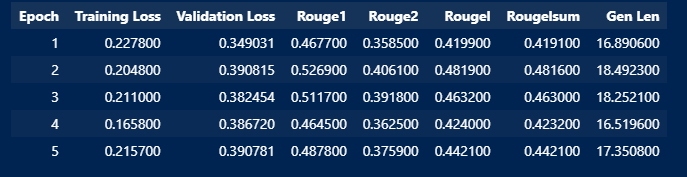

# Inference

In [66]:
from transformers import AutoTokenizer

idx = -69
text = dataset_dict['train'][idx]['text']
inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_new_tokens=100, do_sample=False)
summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
# overfit_accomplished = dataset_dict['train'][0]['summary'] == summary
# print("overfit_accomplished=",overfit_accomplished)
print("input=", dataset_dict['train'][idx]['text'])
print("ground truth=",dataset_dict['train'][idx]['summary'])
print("raw inference=",summary )


input= Speaker 1: No, I-I mean your-your old best friend, here. Lily, from high school. Remember? Speaker 2: Oh gosh, Lily, yes. Of course I remember Lily. I... Then you must be? Speaker 1: Phoebe. Phoebe. Phoebe, yeah. She named me after you I guess.
ground truth= Speaker 1 is a parent of Lily. Lily is a child of Speaker 1.
raw inference= Speaker 2 is a parent of Lily. Lily is a child of Speaker 2.


: 

In [54]:
# @todo: create a custom loss
# first inspect this

import inspect
from transformers import Seq2SeqTrainer

# print(inspect.getsource(Seq2SeqTrainer.training_step))
# print(inspect.getsource(Seq2SeqTrainer.compute_loss))
# print(inspect.getsource(Seq2SeqTrainer.label_smoother))

# # then overwrite the methods (either compute_loss or training_step, or even both)

# from transformers import Seq2SeqTrainer

# class CustomSeq2SeqTrainer(Seq2SeqTrainer):
#     def training_step(self, model, inputs):
#         outputs = model(**inputs)
#         loss = outputs.loss
#         logits = outputs.logits

#         # Add your custom loss here, let's say L1 regularization
#         lambda_l1 = 0.01  # regularization coefficient
#         l1_norm = sum(p.abs().sum() for p in model.parameters())
#         loss = loss + lambda_l1 * l1_norm

#         self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         return {"loss": loss}

# # lastly the trainer

# trainer = CustomSeq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_data["train"],
#     eval_dataset=tokenized_data["test"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics,
# )



In [56]:

# model = AutoModelForSeq2SeqLM.from_pretrained("stevhliu/my_awesome_billsum_model")